<a href="https://colab.research.google.com/github/ykitaguchi77/Laboratory_course/blob/master/11.%20GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GradCAM 診断根拠の可視化**

https://qiita.com/m__k/items/0a841a1a93d70a663c39

https://zenn.dev/iq108uni/articles/7269a1b72f42be

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode
np.random.seed(1234)


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#オリジナルデータセットでない場合にはdataset.zipを解凍
!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

shutil.move("/content/train/appl", "/content/appl")
shutil.move("/content/train/stra", "/content/stra")
shutil.rmtree("/content/train")
shutil.rmtree("/content/val")

Tue, 27 Jan 2026 02:17:06 +0000
Tue, 27 Jan 2026 02:17:12 +0000
drive  sample_data  train  val


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


処理する画像数: 1
--------------------------------------------------

[1/1]
Image: /content/appl/000169072_640.jpg
Pred: appl  100.0%


/tmp/ipython-input-3790197396.py:104: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print(f'Pred: {class_names[c]}  {100*float(p):.1f}%')


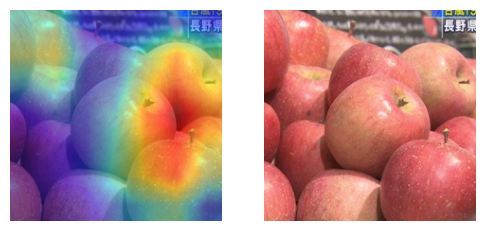

In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# 設定
class_names = ["appl", "stra"]
model_path = '/content/drive/My Drive/AI_laboratory_course/classification.pth'

# 画像の指定方法（以下のいずれかを使用）
# 方法1: 単一画像のパス
image_path = '/content/appl/000169072_640.jpg'

# 方法2: 画像パスのリスト
# image_path = [
#     '/content/appl/000169072_640.jpg',
#     '/content/stra/sample1.jpg',
#     '/content/stra/sample2.jpg'
# ]

# 方法3: フォルダパス（フォルダ内の全画像を処理）
# image_path = '/content/appl'

# デバイス設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルのロード
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load(model_path, map_location=device))
model_ft = model_ft.to(device)

# 前処理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

def get_image_paths(path_input):
    """パス入力から画像パスのリストを取得"""
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff']

    if isinstance(path_input, list):
        # リストの場合はそのまま返す
        return path_input
    elif os.path.isdir(path_input):
        # フォルダの場合は画像ファイルを検索
        image_paths = []
        for ext in image_extensions:
            image_paths.extend(glob.glob(os.path.join(path_input, ext)))
            image_paths.extend(glob.glob(os.path.join(path_input, ext.upper())))
        return sorted(image_paths)
    else:
        # 単一ファイルの場合はリストにして返す
        return [path_input]

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.to(device))
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

def process_single_image(img_path, model_ft, class_names, features_fn, classifier_fn):
    """単一画像を処理"""
    # 画像読み込み
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)

    # 表示用（正規化前）
    display_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    img_display = display_transform(img_pil).permute(1, 2, 0).numpy()

    # 推論
    pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)

    for p, c in zip(pp[0], cc[0]):
        sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
        sal = Image.fromarray(sal).resize((224, 224), resample=Image.Resampling.BILINEAR)

        print(f'Image: {img_path}')
        print(f'Pred: {class_names[c]}  {100*float(p):.1f}%')

        plt.figure(figsize=(6, 4))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(img_display)
        plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(img_display)
        plt.show()

def process_images(path_input, model_ft, class_names):
    """画像を処理（単一パス、リスト、フォルダに対応）"""
    # モデル分割
    features_fn = nn.Sequential(*list(model_ft.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:]))

    model_ft.eval()

    # 画像パスを取得
    image_paths = get_image_paths(path_input)

    print(f"処理する画像数: {len(image_paths)}")
    print("-" * 50)

    for i, img_path in enumerate(image_paths):
        print(f"\n[{i+1}/{len(image_paths)}]")
        try:
            process_single_image(img_path, model_ft, class_names, features_fn, classifier_fn)
        except Exception as e:
            print(f"エラー: {img_path} - {e}")

# 実行
process_images(image_path, model_ft, class_names)

#**何をしているのかを確認**

###**微分**

torch.autograd.grad(outputs=y, inputs=x, create_graph=True)

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y = x**3
grads = torch.autograd.grad(outputs=y, inputs=x, create_graph=True)
print(grads)
print(grads[0])

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y = x**3
y.backward()
print(x.grad)

###**Global Average Pooling**

w = grads[0][0].mean(-1).mean(-1)

In [ ]:
# 形状が[6, 4, 3]のテンソルの作成
x = torch.tensor([
    [
        [1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]
    ],
    [
        [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24]
    ],
    [
        [25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36]
    ],
    [
        [37, 38, 39], [40, 41, 42], [43, 44, 45], [46, 47, 48]
    ],
    [
        [49, 50, 51], [52, 53, 54], [55, 56, 57], [58, 59, 60]
    ],
    [
        [61, 62, 63], [64, 65, 66], [67, 68, 69], [70, 71, 72]
    ]
], dtype=torch.float)

x.size()

torch.Size([6, 4, 3])

In [ ]:
print(x.mean(-1))
print(x.mean(-1).size())

tensor([[ 2.,  5.,  8., 11.],
        [14., 17., 20., 23.],
        [26., 29., 32., 35.],
        [38., 41., 44., 47.],
        [50., 53., 56., 59.],
        [62., 65., 68., 71.]])
torch.Size([6, 4])


In [ ]:
print(x.mean(-1).mean(-1))
print(x.mean(-1).mean(-1).size())

tensor([ 6.5000, 18.5000, 30.5000, 42.5000, 54.5000, 66.5000])
torch.Size([6])
